In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
##from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

In [2]:
df_credits = pd.read_csv(r"C:\Users\Vivian\OneDrive\桌面\movies_metadata.csv\credits.csv", encoding = "ISO-8859-1")
df_meta = pd.read_csv(r"C:\Users\Vivian\OneDrive\桌面\movies_metadata.csv\movies_metadata.csv")


In [3]:
X = pd.DataFrame()
df_meta['release_date'] = pd.to_datetime(df_meta['release_date'], errors='coerce')
X['year'] =df_meta['release_date'].dt.year
X['id'] = df_meta['id'].astype(str).apply(lambda x: x.replace('-','0'))
X =pd.merge(X, df_meta, on='id')
X =X.drop(['belongs_to_collection','homepage','homepage','poster_path','tagline','video','adult','imdb_id','status', 'overview', 'id', 'title'],axis=1)

In [4]:
import ast
X['genres'] = X['genres'].apply(lambda x : ast.literal_eval(x))
X['genres'] =X['genres'].apply(lambda lst: [x['name'] for x in lst] if isinstance(lst, list) and len(lst) > 0 else lst)

X['production_companies'] = X['production_companies'].apply(lambda x : ast.literal_eval(x) if pd.notna(x) else x)
X['production_companies'] = X['production_companies'].apply(lambda lst: [x['name'] for x in lst] if isinstance(lst, list) and len(lst) > 0 else np.nan)

X['spoken_languages'] = X['spoken_languages'].apply(lambda x : ast.literal_eval(x) if pd.notna(x) else x)
X['spoken_languages'] = X['spoken_languages'].apply(lambda lst: [x['name'] for x in lst] if isinstance(lst, list) and len(lst) > 0 else np.nan)

X['production_countries'] = X['production_countries'].apply(lambda x : ast.literal_eval(x) if pd.notna(x) else x)
X['production_countries'] = X['production_countries'].apply(lambda lst: [x['name'] for x in lst] if isinstance(lst, list) and len(lst) > 0 else np.nan)

In [5]:
X =X.dropna()

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_data = mlb.fit_transform(X['genres'])
genres_X = pd.DataFrame(genres_data, columns=mlb.classes_)

from sklearn.preprocessing import MultiLabelBinarizer
mlb1 = MultiLabelBinarizer()
pc_data = mlb1.fit_transform(X['production_countries'])
pc_X = pd.DataFrame(pc_data, columns=mlb1.classes_)

from sklearn.preprocessing import MultiLabelBinarizer
mlb1 = MultiLabelBinarizer()
lg_data = mlb1.fit_transform(X['spoken_languages'])
lg_X = pd.DataFrame(lg_data, columns=mlb1.classes_)

In [7]:
ml_X = pd.DataFrame()
# ml_X = pd.merge(X, lg_X, left_index =True, right_index =True)
# ml_X = pd.merge(ml_X, pc_X, left_index =True, right_index =True)
ml_X = pd.merge(X, genres_X, left_index =True, right_index =True)
ml_X = ml_X.drop(columns =['genres', 'original_language', 'original_title', 'production_companies', 'production_countries', 'spoken_languages', 'release_date'], axis =1)
# ml_X = ml_X.drop(columns =['genres', 'original_language', 'original_title', 'production_companies', 'production_countries', 'spoken_languages', 'release_date'])
ml_X['budget'] =ml_X['budget'].astype(int)
ml_X['popularity'] = ml_X['popularity'].astype(float)

In [8]:
from sklearn.model_selection import train_test_split
y =ml_X['vote_average']
ml_X =ml_X.drop(['vote_average'], axis=1)
X_train, X_test, y_train, y_test =train_test_split(ml_X, y, test_size =.2, random_state = 100)

In [9]:
from sklearn.linear_model import LinearRegression
lm =LinearRegression()
lm.fit(X_train, y_train)
pred_lm =lm.predict(ml_X)

In [10]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
prec_rf=rf.predict(ml_X)

In [11]:
res = np.column_stack((y, pred_lm))
res = np.column_stack((res, prec_rf))

In [12]:
prediction = pd.DataFrame(res, columns=["Rating", "rating_lm", "rating_rf"])
prediction

,Rating,rating_lm,rating_rf
0,7.7,7.639926,7.511
1,6.9,6.503181,6.936
2,6.5,6.153126,6.342
3,6.1,6.120625,6.173
4,5.7,5.987128,5.805
...,...,...,...
24325,6.0,5.790123,5.625
24326,0.0,5.716530,0.000
24327,5.0,5.716547,5.392
24328,3.8,7.120138,3.979


In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ml_X, y, test_size=0.2, random_state=2023)

# Create a pipeline with PolynomialFeatures and LinearRegression
degree = 2  # Set the degree of polynomial features
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# testing

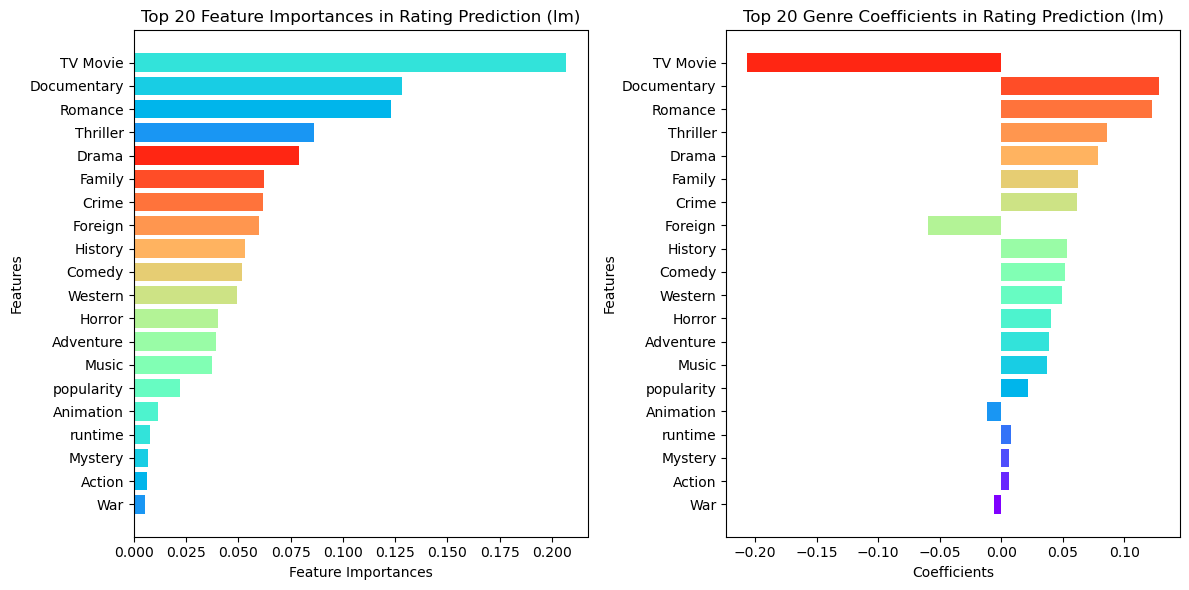

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

lm =LinearRegression()
lm.fit(X_train, y_train)
pred_lm =lm.predict(ml_X)

n = 20
abs_importances = np.abs(lm.coef_)
sorted_indices = np.argsort(abs_importances)[::-1]

top_10_importances = abs_importances[sorted_indices[:n]]
top_10_indices = sorted_indices[:n]
top_10_labels = [ml_X.columns[i] for i in top_10_indices]

top_10_importances = top_10_importances[::-1]
top_10_labels = top_10_labels[::-1]

color_map = plt.cm.get_cmap('rainbow')

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the feature importances
axes[0].barh(range(len(top_10_importances)), top_10_importances, align='center', color=color_map(np.arange(4, len(top_10_importances)) / len(top_10_importances)))
axes[0].set_yticks(range(len(top_10_importances)))
axes[0].set_yticklabels(top_10_labels)
axes[0].set_xlabel('Feature Importances')
axes[0].set_ylabel('Features')
axes[0].set_title(f'Top {n} Feature Importances in Rating Prediction (lm)')

# Plot the coefficients
coefficients = lm.coef_
top_10_coefficients = coefficients[sorted_indices[:n]]
top_10_feature_names = ml_X.columns[sorted_indices[:n]]
top_10_coefficients = top_10_coefficients[::-1]
top_10_feature_names = top_10_feature_names[::-1]

axes[1].barh(range(len(top_10_coefficients)), top_10_coefficients, align='center', color=color_map(np.arange(len(top_10_coefficients)) / len(top_10_coefficients)))
axes[1].set_yticks(range(len(top_10_coefficients)))
axes[1].set_yticklabels(top_10_feature_names)
axes[1].set_xlabel('Coefficients')
axes[1].set_ylabel('Features')
axes[1].set_title(f'Top {n} Genre Coefficients in Rating Prediction (lm)')

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplot
plt.show()


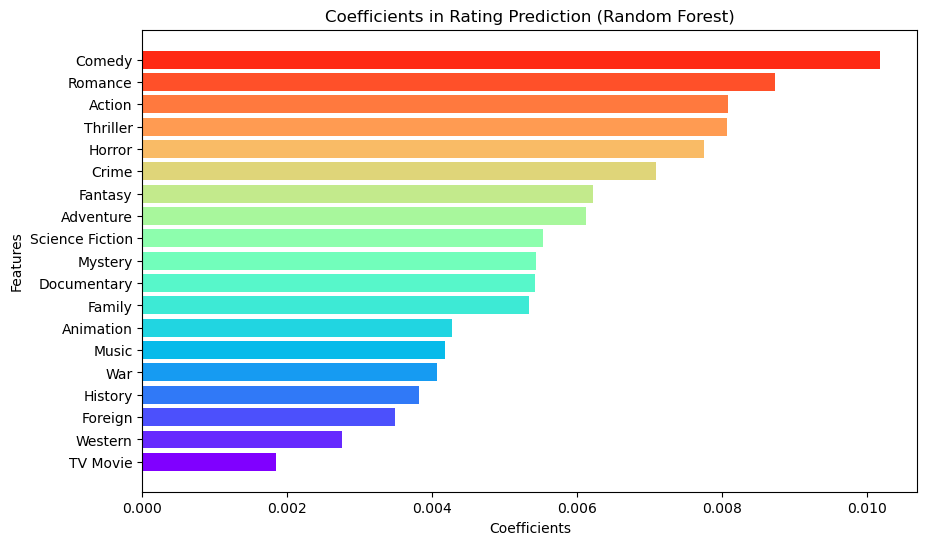

In [15]:
import numpy as np
import matplotlib.pyplot as plt

n = 30
coefficients = rf.feature_importances_
sorted_indices = np.argsort(coefficients)[::-1]

top_10_coefficients = coefficients[sorted_indices[7:n]]
top_10_feature_names = ml_X.columns[sorted_indices[7:n]]

top_10_coefficients = top_10_coefficients[::-1]
top_10_feature_names = top_10_feature_names[::-1]

color_map = plt.cm.get_cmap('rainbow')

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_10_coefficients)), top_10_coefficients, align='center', color=color_map(np.arange(len(top_10_coefficients)) / len(top_10_coefficients)))
plt.yticks(range(len(top_10_coefficients)), top_10_feature_names)
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title(f'Coefficients in Rating Prediction (Random Forest)')

plt.show()


In [16]:
from sklearn.metrics import mean_squared_error
mse_rf = mean_squared_error(y, prec_rf)
mse_lm = mean_squared_error(y, pred_lm)
print(mse_rf, mse_lm)

0.32983790415125364 1.9724120582928704


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import random

best_rf =None
best_mse =100

for i in range(20):
    X_train, X_test, y_train, y_test =train_test_split(ml_X, y, test_size =.2, random_state = random.randint(1, 2023))
    rf = RandomForestRegressor()
    rf.fit(X_train,y_train)
    prec_rf=rf.predict(ml_X)
    mse =mean_squared_error(y, prec_rf)
    print(str(mse)[:4], end=' ')
    if (mse < best_mse):
        best_rf = rf
        best_mse = mse

0.31 0.31 0.31 0.31 0.32 0.31 0.31 0.32 0.31 0.31 0.32 0.31 0.31 0.31 0.31 0.31 0.32 0.31 0.31 0.32 

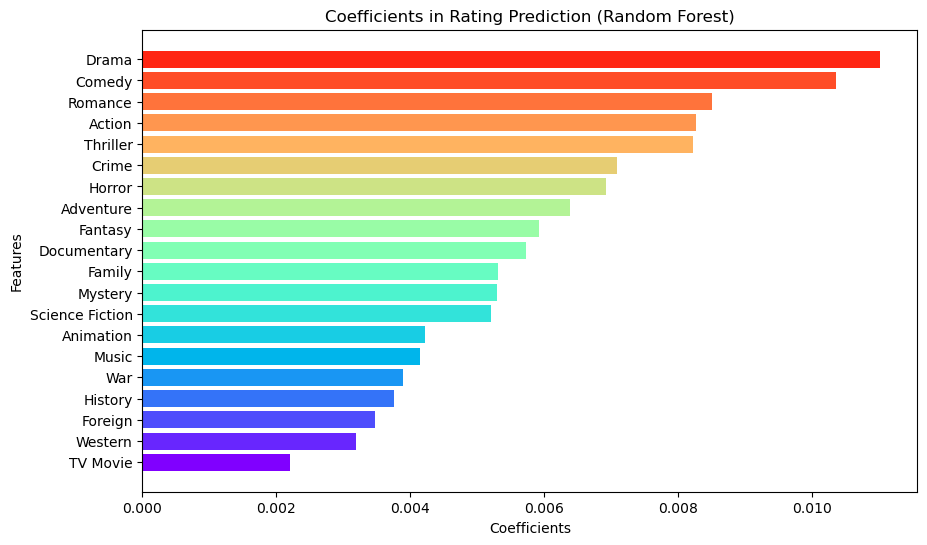

In [18]:
import numpy as np
import matplotlib.pyplot as plt

n = 30
coefficients = best_rf.feature_importances_
sorted_indices = np.argsort(coefficients)[::-1]

top_10_coefficients = coefficients[sorted_indices[6:n]]
top_10_feature_names = ml_X.columns[sorted_indices[6:n]]

top_10_coefficients = top_10_coefficients[::-1]
top_10_feature_names = top_10_feature_names[::-1]

color_map = plt.cm.get_cmap('rainbow')

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_10_coefficients)), top_10_coefficients, align='center', color=color_map(np.arange(len(top_10_coefficients)) / len(top_10_coefficients)))
plt.yticks(range(len(top_10_coefficients)), top_10_feature_names)
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title(f'Coefficients in Rating Prediction (Random Forest)')

plt.show()